# get token importance values

In [ ]:
! wget -O esm_resid_importances_all_proteins.npz https://zenodo.org/records/14080821/files/esm2_650m_residue_importances.npz?download=1

In [ ]:
! wget -O protbert_resid_importances_all_proteins.npz https://zenodo.org/records/14080821/files/protbert_residue_importances.npz?download=1

In [1]:
import numpy as np
esm_all_proteins = np.load('esm_resid_importances_all_proteins.npz')
protbert_all_proteins = np.load('protbert_resid_importances_all_proteins.npz')

In [2]:
protbert_proteins = list(protbert_all_proteins.keys())
esm_proteins = list(esm_all_proteins.keys())

# analysis

In [17]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [21]:
import utils
import os

In [22]:
import matplotlib.pyplot as plt

In [23]:
from tqdm import tqdm

# check for catalytic site atlas

In [7]:
! wget -O curated_data_CSA.csv https://www.ebi.ac.uk/thornton-srv/m-csa/media/flat_files/curated_data.csv

--2025-03-12 17:03:54--  https://www.ebi.ac.uk/thornton-srv/m-csa/media/flat_files/curated_data.csv
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2799138 (2.7M) [application/octet-stream]
Saving to: ‘curated_data_CSA.csv’

100%[======================================>] 2,799,138   2.66MB/s   in 1.0s   

2025-03-12 17:03:56 (2.66 MB/s) - ‘curated_data_CSA.csv’ saved [2799138/2799138]



In [8]:
import pandas as pd

In [9]:
df_csa = pd.read_csv('curated_data_CSA.csv', sep=',', on_bad_lines='skip')

In [10]:
df_csa

,M-CSA ID,Uniprot IDs,PDB,EC,residue/reactant/product/cofactor,PDB code,chain/kegg compound,resid/chebi id,function location/name,role,role type,role group
0,M0001,P56868,1b73,5.1.1.3,residue,Asp,A,7,side_chain,activator,spectator,activator
1,M0001,P56868,1b73,5.1.1.3,residue,Asp,A,7,side_chain,hydrogen bond acceptor,interaction,NaN
2,M0001,P56868,1b73,5.1.1.3,residue,Asp,A,7,side_chain,proton acceptor,reactant,proton shuttle (general acid/base)
3,M0001,P56868,1b73,5.1.1.3,residue,Asp,A,7,side_chain,electrostatic stabiliser,spectator,electrostatic interaction
4,M0001,P56868,1b73,5.1.1.3,residue,Asp,A,7,side_chain,hydrogen bond donor,interaction,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23760,M0966,P15723,4x9e,3.1.5.1,residue,His,A,117,side_chain,metal ligand,interaction,NaN
23761,M0966,P15723,4x9e,3.1.5.1,residue,Asp,A,118,side_chain,metal ligand,interaction,NaN
23762,M0966,P15723,4x9e,3.1.5.1,residue,Asp,A,268,side_chain,metal ligand,interaction,NaN
23763,M0966,P15723,4x9e,3.1.5.1,residue,Arg,B,442,side_chain,unknown,spectator,NaN


In [11]:
list_csa_prots = list(df_csa['Uniprot IDs'].unique())

In [12]:
list_csa_prots_human = []
for prot in list_csa_prots:
    if prot in esm_proteins:
        list_csa_prots_human.append(prot)

In [13]:
df_csa_human = df_csa[df_csa['Uniprot IDs'].isin(list_csa_prots_human)].reset_index()

In [24]:
percentiles_csa_esm = np.ones(len(df_csa_human))*1000
for i, row in tqdm(df_csa_human.iterrows(), total = len(df_csa_human)):
    try:
        acc = row['Uniprot IDs']
        res_index = row['resid/chebi id'] - 1
        esm_importances = esm_all_proteins[acc]
        if res_index >= len(esm_importances):
            continue
        esm_percentiles = utils.importances_to_percentiles(esm_importances)
        percentile = esm_percentiles[res_index]
        percentiles_csa_esm[i] = percentile
    except Exception as e:
        raise Exception(e)
        continue

threshold = 100

# Filter out elements larger than the threshold
percentiles_csa_esm = percentiles_csa_esm[percentiles_csa_esm <= threshold]

100%|██████████| 2101/2101 [00:03<00:00, 600.90it/s]


In [25]:
len(percentiles_csa_esm)

1942

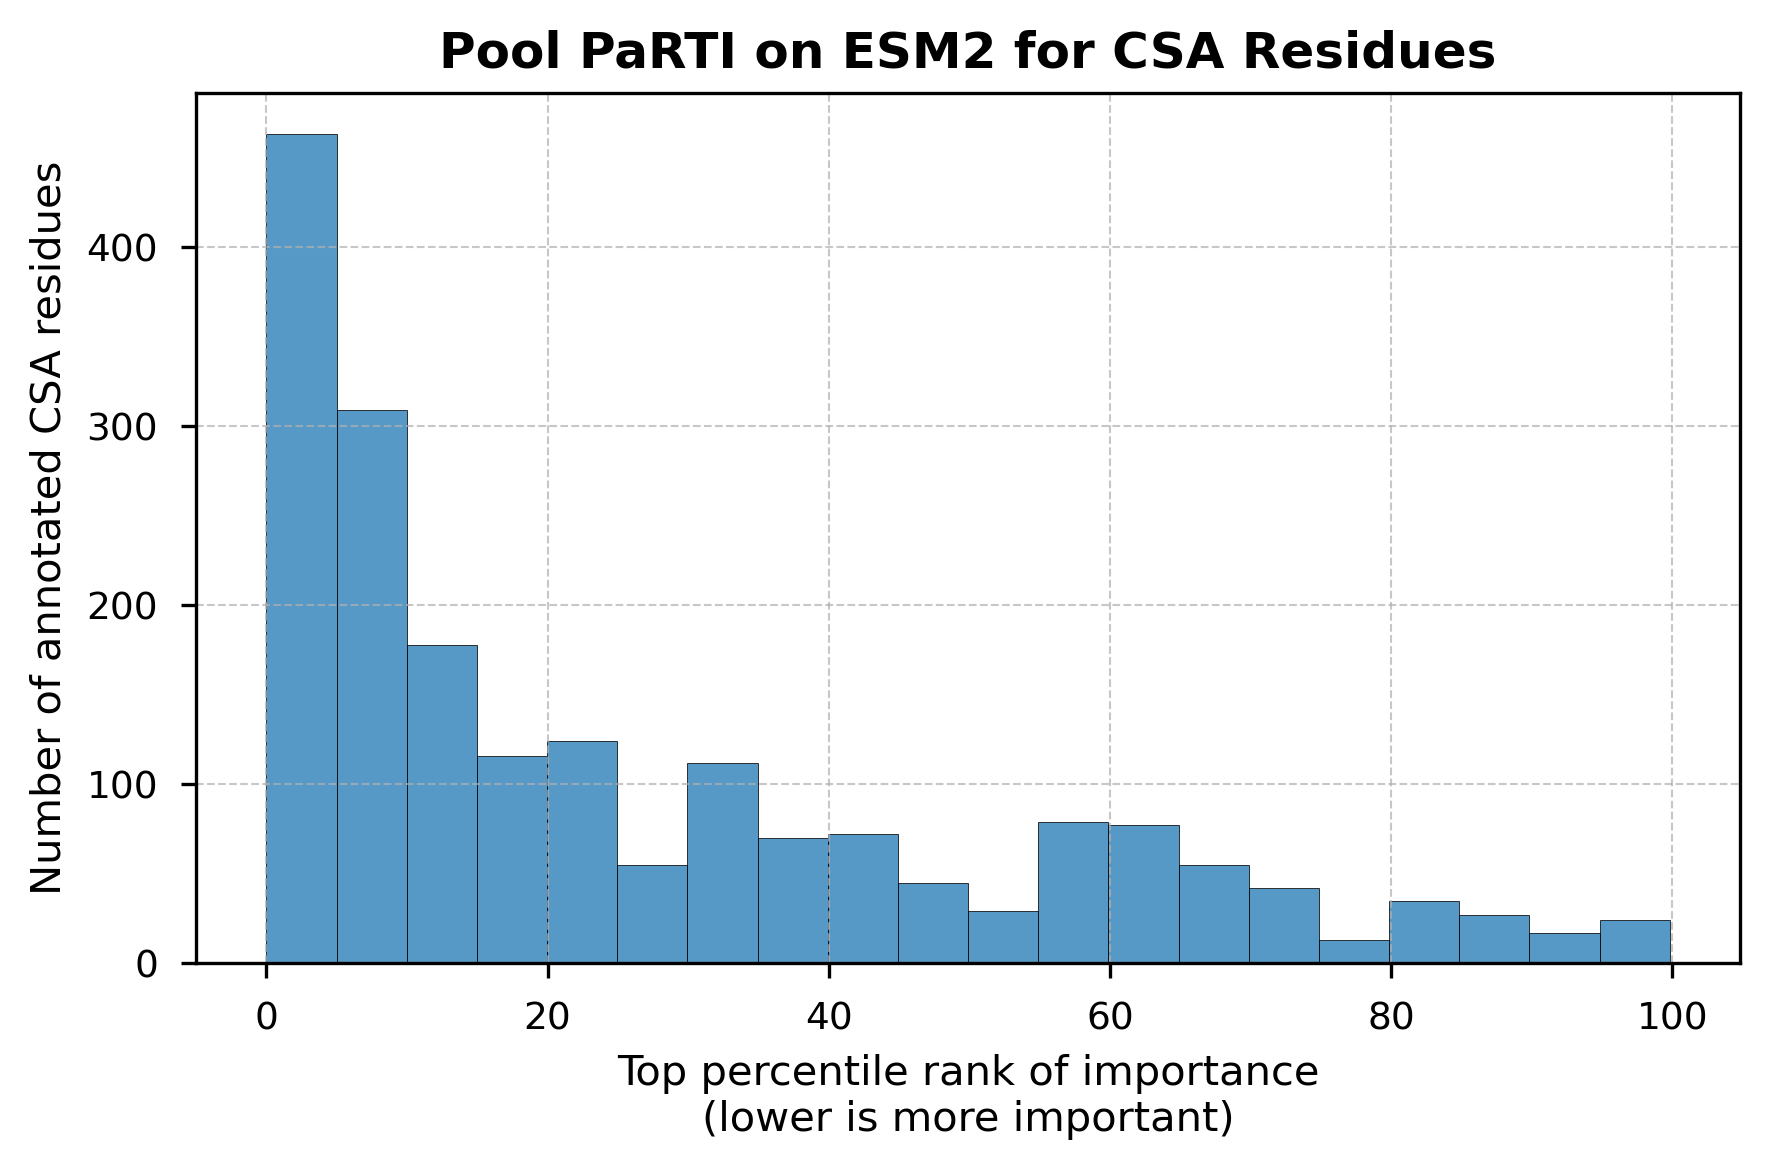

In [34]:
import matplotlib.pyplot as plt

# Use a publication-friendly style
plt.style.use("seaborn-v0_8-paper")

# Create the histogram
plt.figure(figsize=(6, 4), dpi=300)  # High resolution
plt.hist(percentiles_csa_esm, bins=20, edgecolor='black', alpha=0.75)

# Improve labels and title
plt.title("Pool PaRTI on ESM2 for CSA Residues", fontsize=12, fontweight='bold')
plt.xlabel("Top percentile rank of importance\n(lower is more important)", fontsize=10)
plt.ylabel("Number of annotated CSA residues", fontsize=10)

# Improve ticks
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Add minor grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show or save the figure
plt.savefig("figs/Fig#291#_pool_parti_csa_esm2.png", dpi=300, bbox_inches="tight")
plt.show()



In [27]:
percentiles_csa_protbert = np.ones(len(df_csa_human))*1000
for i, row in tqdm(df_csa_human.iterrows(), total = len(df_csa_human)):
    try:
        acc = row['Uniprot IDs']
        res_index = row['resid/chebi id'] - 1
        protbert_importances = protbert_proteins[acc]
        if res_index >= len(protbert_importances):
            continue
        protbert_percentiles = utils.importances_to_percentiles(protbert_importances)
        percentile = protbert_percentiles[res_index]
        percentiles_csa_protbert[i] = percentile
    except Exception as e:
        continue

threshold = 100

# Filter out elements larger than the threshold
percentiles_csa_protbert = percentiles_csa_protbert[percentiles_csa_protbert <= threshold]

100%|██████████| 2101/2101 [00:04<00:00, 429.24it/s]


In [28]:
len(percentiles_csa_protbert)

1842

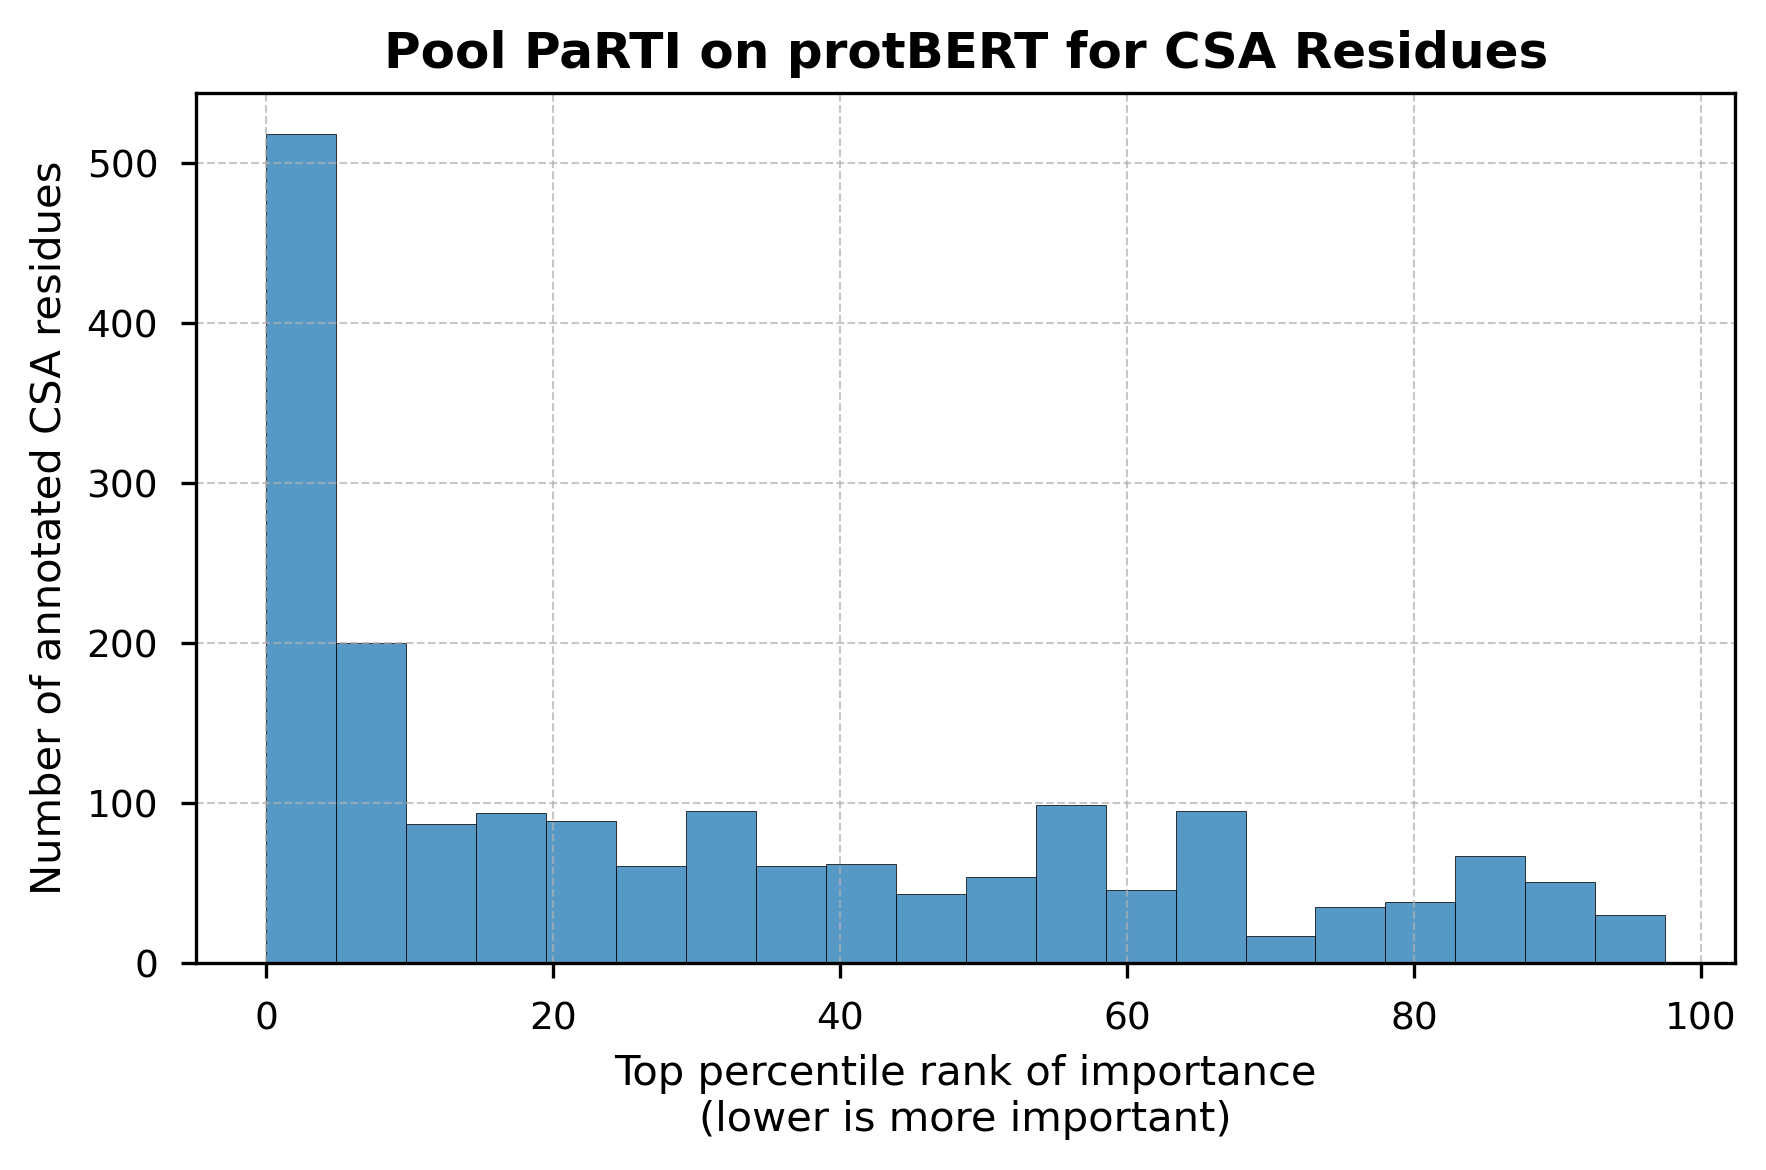

In [35]:
import matplotlib.pyplot as plt

# Use a publication-friendly style
plt.style.use("seaborn-v0_8-paper")

# Create the histogram
plt.figure(figsize=(6, 4), dpi=300)  # High resolution
plt.hist(percentiles_csa_protbert, bins=20, edgecolor='black', alpha=0.75)

# Improve labels and title
plt.title("Pool PaRTI on protBERT for CSA Residues", fontsize=12, fontweight='bold')
plt.xlabel("Top percentile rank of importance\n(lower is more important)", fontsize=10)
plt.ylabel("Number of annotated CSA residues", fontsize=10)

# Improve ticks
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Add minor grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show or save the figure
plt.savefig("figs/Fig#292#_pool_parti_csa_protbert.png", dpi=300, bbox_inches="tight")
plt.show()

